<a href="https://colab.research.google.com/github/asante69/Data-Analyst/blob/main/Sentiment_Analysis_and_Model_Testing_Construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import your libraries for sentiment analysis

In [2]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!python -m nltk.downloader punkt
!pip install pandas
!pip install pyLDAvis
!pip install sklearn
!pip install gensim

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 34.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  

In [3]:
import numpy as np
import datetime as dt
import pandas as pd
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import string
import re
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
import networkx as nx

import gensim
from gensim.utils import simple_preprocess
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Load your scrapped Data

In [4]:
try:
    df1 = pd.read_csv('BLD.csv')
    df2 = pd.read_csv('DHI.csv')
    df3 = pd.read_csv('IBP.csv')
    df4 = pd.read_csv ('UFPI.csv')

    # Concatenate the dataframes
    df = pd.concat([df1, df2, df3], ignore_index=True)

    # Print some info about the concatenated dataframe (optional)
    print(df.info())

except FileNotFoundError:
    print("One or more data files not found. Please check the filenames and paths.")
except pd.errors.EmptyDataError:
    print("One or more data files are empty.")
except Exception as e:
    print(f"An error occurred: {e}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     3122 non-null   object
 1   Comment  3032 non-null   object
dtypes: object(2)
memory usage: 48.9+ KB
None


In [5]:
df.head()

,Date,Comment
0,23/2/25,💎 MYNZ 🚀 NEW product hint and upcoming MAJOR p...
1,24/2/25,- TopBuild Corp. Common Stock - 10K - Updated ...
2,25/2/25,EXPANDED BUYBACK
3,25/2/25,"TopBuild sees 2025 revenue $5.05B-$5.35B, cons..."
4,25/2/25,"TopBuild reports Q4 EPS $5.11, consensus $5.05..."


In [ ]:
#df = pd.read_csv("/content/Manufacturing.csv")
#df.head()

In [14]:
df['Comment'].nunique()

2603

In [13]:
df.duplicated().sum()

0

In [12]:
df.drop_duplicates(keep='first', inplace=True)

##Load Stopwords

In [15]:
# Load stop words
stop_words = stopwords.words('english')

# Show stop words
stop_words[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

##Perform data cleaning by removing hastags, urls, mentions, symbols, www, pictures, emoji, etc

In [16]:

# Removing hashtags and mentions
def get_hashtags(text):
    hashtags = re.findall(r'\#\w+',text.lower())
    return hashtags
def get_mentions(text):
    mentions = re.findall(r'\@\w+',text.lower())
    return mentions

# Cleaning up the text of the tweets
def remove_content(text):
    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) #remove urls
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    return text

def process_tweet(tweet):
    """
    tweets cleaning by
    1) lowering the case of the tweet,
    2) removing unwanted symbols and replacing them with a whitespace,
    3) split sentences into words according to whitespaces and then
    4) join back with a single whitespace as separator between various words
    """
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

def process_text(text, stem=False): #clean text
    text=remove_content(text)
    lemmatizer=WordNetLemmatizer()
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    text = re.sub(r'@[A-Za-z0-9]+', '', str(text)) # remove @mentions
    text = re.sub(r'#', '',  str(text)) # remove the '#' symbol
    text = re.sub(r'RT[\s]+', '',  str(text)) # remove RT
    text = re.sub(r'https?\/\/S+', '',  str(text)) # remove the hyperlink
    text = re.sub(r'http\S+', '',  str(text)) # remove the hyperlink
    text = re.sub(r'www\S+', '',  str(text)) # remove the www
    text = re.sub(r'pic+', '',  str(text)) # remove the pic
    text = re.sub(r'com', '',  str(text)) # remove the pic
    text = re.sub(r"\bamp\b", ' ', text.lower()) #remove "amp" which is coming from the translation of &
    text = re.sub(r"\bco\b", ' ', text.lower()) #remove "co" which was one of the top words found below
    tokenized_text = word_tokenize(text) #tokenize
    #tokenized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    clean_text = [
         word for word in tokenized_text
         if (word not in stop_words and len(word)>1)
    ]
    if stem:
        clean_text=[stemmer.stem(word) for word in clean_text]
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
    return ' '.join(clean_text)

#functions used to remove search terms from all the tweets
#function to remove duplicates from a string - in this case the string is the keywords used to scrape the tweets
def removeDupWithoutOrder(string):
    words = string.lower().split()
    return " ".join(sorted(set(words), key=words.index)).replace('OR', '').replace('  ', ' ')

#function to search for string i.e. remove specific words (search_terms in this case)
def remove_search(text, search_terms):
    query = text.lower()
    querywords = query.split()
    resultwords  = [word for word in querywords if word.lower() not in search_terms]
    return ' '.join(resultwords)

# define function to plot frequency of bi-grams, tri-grams, single words, phrases etc
from sklearn.feature_extraction.text import CountVectorizer
def plot_topn(sentences, ngram_range=(1,3), top=20,firstword=''):
    c=CountVectorizer(ngram_range=ngram_range)
    X=c.fit_transform(sentences)
    words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
    res=words[words['index'].apply(lambda x: firstword in x)].head(top)
    pl=px.bar(res, x='index',y=0)
    pl.update_layout(yaxis_title='count',xaxis_title='Phrases')

In [17]:
import re
re.compile('<title>(.*)</title>')

re.compile(r'<title>(.*)</title>', re.UNICODE)

In [18]:
# removing useless content (hashtags, mentions)
df['Comment'].apply(str)

,Comment
0,💎 MYNZ 🚀 NEW product hint and upcoming MAJOR p...
1,- TopBuild Corp. Common Stock - 10K - Updated ...
2,EXPANDED BUYBACK
3,"TopBuild sees 2025 revenue $5.05B-$5.35B, cons..."
4,"TopBuild reports Q4 EPS $5.11, consensus $5.05..."
...,...
3116,[15s. delayed]: Issued Press Release on Octobe...
3117,Installed Building Products to Report Third Qu...
3119,+0.9% \n\nAcquires Norkote\n\nSee Full Analysis:
3120,"[15s. delayed] filed form 8-K on October 26, 1..."


In [19]:
df['cleaned_comments'] = df['Comment'].astype(str).apply(lambda x: process_tweet(x))

In [20]:
df

,Date,Comment,cleaned_comments
0,23/2/25,💎 MYNZ 🚀 NEW product hint and upcoming MAJOR p...,mynz new product hint and upcoming major partn...
1,24/2/25,- TopBuild Corp. Common Stock - 10K - Updated ...,topbuild corp common stock 10k updated risk fa...
2,25/2/25,EXPANDED BUYBACK,expanded buyback
3,25/2/25,"TopBuild sees 2025 revenue $5.05B-$5.35B, cons...",topbuild sees 2025 revenue 5 05b 5 35b consens...
4,25/2/25,"TopBuild reports Q4 EPS $5.11, consensus $5.05...",topbuild reports q4 eps 5 11 consensus 5 05 re...
...,...,...,...
3116,29/10/20,[15s. delayed]: Issued Press Release on Octobe...,15s delayed issued press release on october 29...
3117,29/10/20,Installed Building Products to Report Third Qu...,installed building products to report third qu...
3119,27/10/20,+0.9% \n\nAcquires Norkote\n\nSee Full Analysis:,0 9 acquires norkote see full analysis
3120,26/10/20,"[15s. delayed] filed form 8-K on October 26, 1...",15s delayed filed form 8 k on october 26 16 15...


###Check the number of comments or reviews in the dataset

In [21]:
df['cleaned_comments'].nunique()

2554

In [22]:
#Save cleaned_comments data
df.to_csv('cleaned_comments.csv', index=False)

In [24]:
df['Comment'] = df['Comment'].str.replace('http\S+', '')


###Generate Word Frequency to analyze the most occuring word within the dataset

In [23]:
from PIL import Image
import urllib
import requests
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

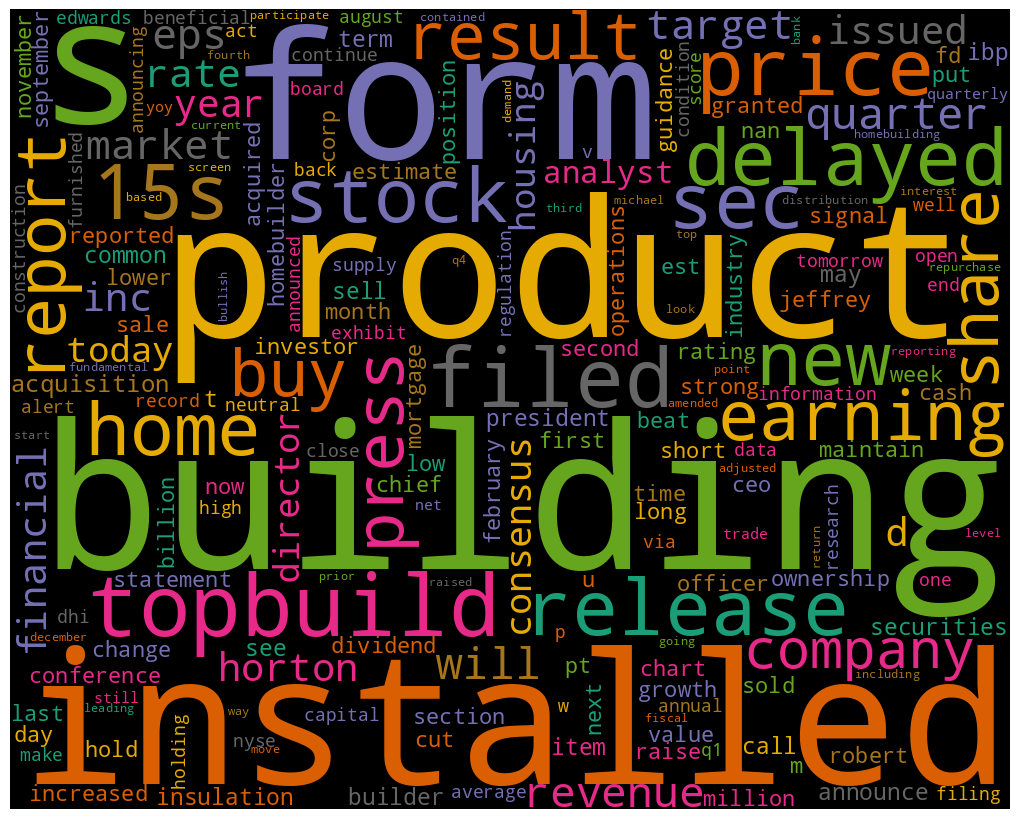

In [25]:
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.cleaned_comments:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 800,
                background_color='black', colormap='Dark2',
                collocations=False,
                stopwords = stopwords,
                min_font_size = 12).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

###Plot Polarity and Subjectivity Scores

In [26]:
def getSubjectivity(text):
    return TextBlob( str(text)).sentiment.subjectivity

def getPolarity(text):
    return TextBlob( str(text)).sentiment.polarity

In [27]:
df.dropna(subset=['cleaned_comments'], inplace = True)
df.reset_index(drop=True, inplace=True)

In [28]:
df['Subjectivity'] = df['cleaned_comments'].apply(getSubjectivity)
df['Polarity'] = df['cleaned_comments'].apply(getPolarity)
df.head()

,Date,Comment,cleaned_comments,Subjectivity,Polarity
0,23/2/25,💎 MYNZ 🚀 NEW product hint and upcoming MAJOR p...,mynz new product hint and upcoming major partn...,0.477273,0.099432
1,24/2/25,- TopBuild Corp. Common Stock - 10K - Updated ...,topbuild corp common stock 10k updated risk fa...,0.222222,-0.155556
2,25/2/25,EXPANDED BUYBACK,expanded buyback,0.000000,0.000000
3,25/2/25,"TopBuild sees 2025 revenue $5.05B-$5.35B, cons...",topbuild sees 2025 revenue 5 05b 5 35b consens...,0.000000,0.000000
4,25/2/25,"TopBuild reports Q4 EPS $5.11, consensus $5.05...",topbuild reports q4 eps 5 11 consensus 5 05 re...,0.554808,0.220192


In [29]:

def get_Polarity_Analysis(score):
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'
def get_Subjectivity_Analysis(score):
    if score >  0:
      return 'Opinion'
    else:
      return 'Fact'

df['Analysis_Polarity'] = df['Polarity'].apply(get_Polarity_Analysis)

df['Analysis_Subjectivity'] = df['Subjectivity'].apply(get_Subjectivity_Analysis)

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=2)

###Plot Polarity and Subjectiviy Score in Scatter Plot

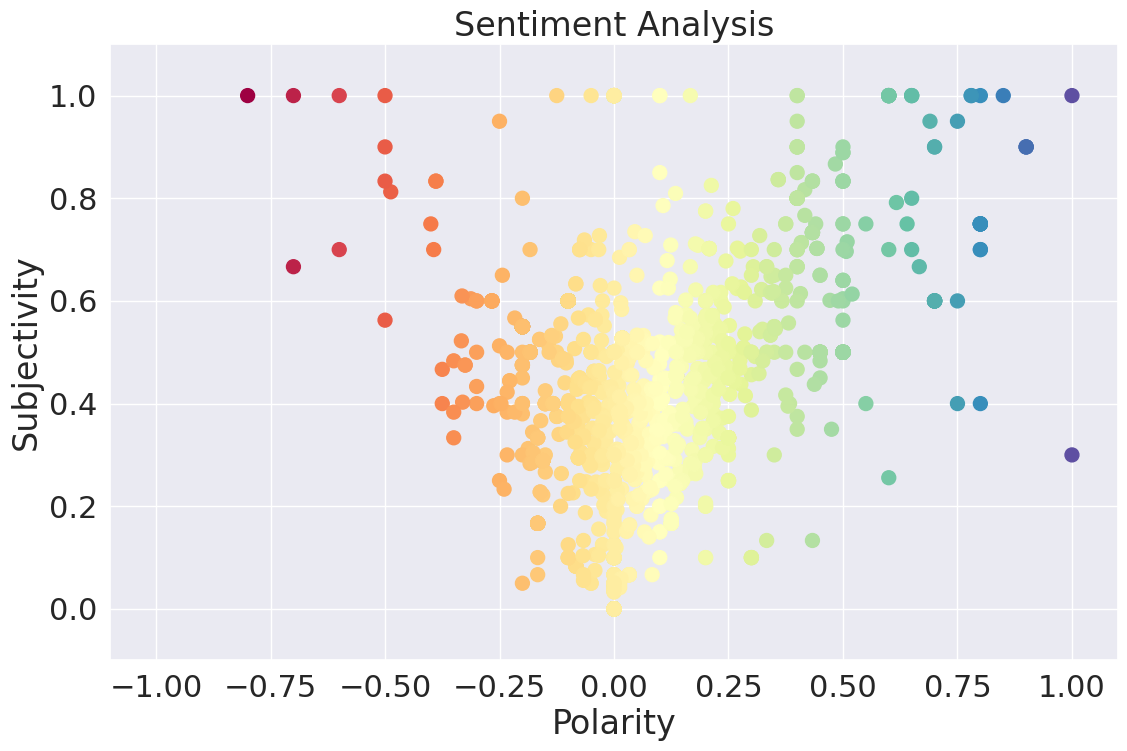

(None,)

In [31]:
plt.figure(figsize=(13,8))

plt.scatter(df['Polarity'], df['Subjectivity'], c=df['Polarity'], s=100, cmap='Spectral')

plt.xlim(-1.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show(),

In [32]:
df['Sentiment'] = df.apply(lambda x: ' '.join([str(x['Analysis_Polarity']),str(x['Analysis_Subjectivity'])]),axis=1)
df.head()


,Date,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment
0,23/2/25,💎 MYNZ 🚀 NEW product hint and upcoming MAJOR p...,mynz new product hint and upcoming major partn...,0.477273,0.099432,Positive,Opinion,Positive Opinion
1,24/2/25,- TopBuild Corp. Common Stock - 10K - Updated ...,topbuild corp common stock 10k updated risk fa...,0.222222,-0.155556,Negative,Opinion,Negative Opinion
2,25/2/25,EXPANDED BUYBACK,expanded buyback,0.000000,0.000000,Neutral,Fact,Neutral Fact
3,25/2/25,"TopBuild sees 2025 revenue $5.05B-$5.35B, cons...",topbuild sees 2025 revenue 5 05b 5 35b consens...,0.000000,0.000000,Neutral,Fact,Neutral Fact
4,25/2/25,"TopBuild reports Q4 EPS $5.11, consensus $5.05...",topbuild reports q4 eps 5 11 consensus 5 05 re...,0.554808,0.220192,Positive,Opinion,Positive Opinion


###Plot Polarity Score for the entire dataset using bar chart

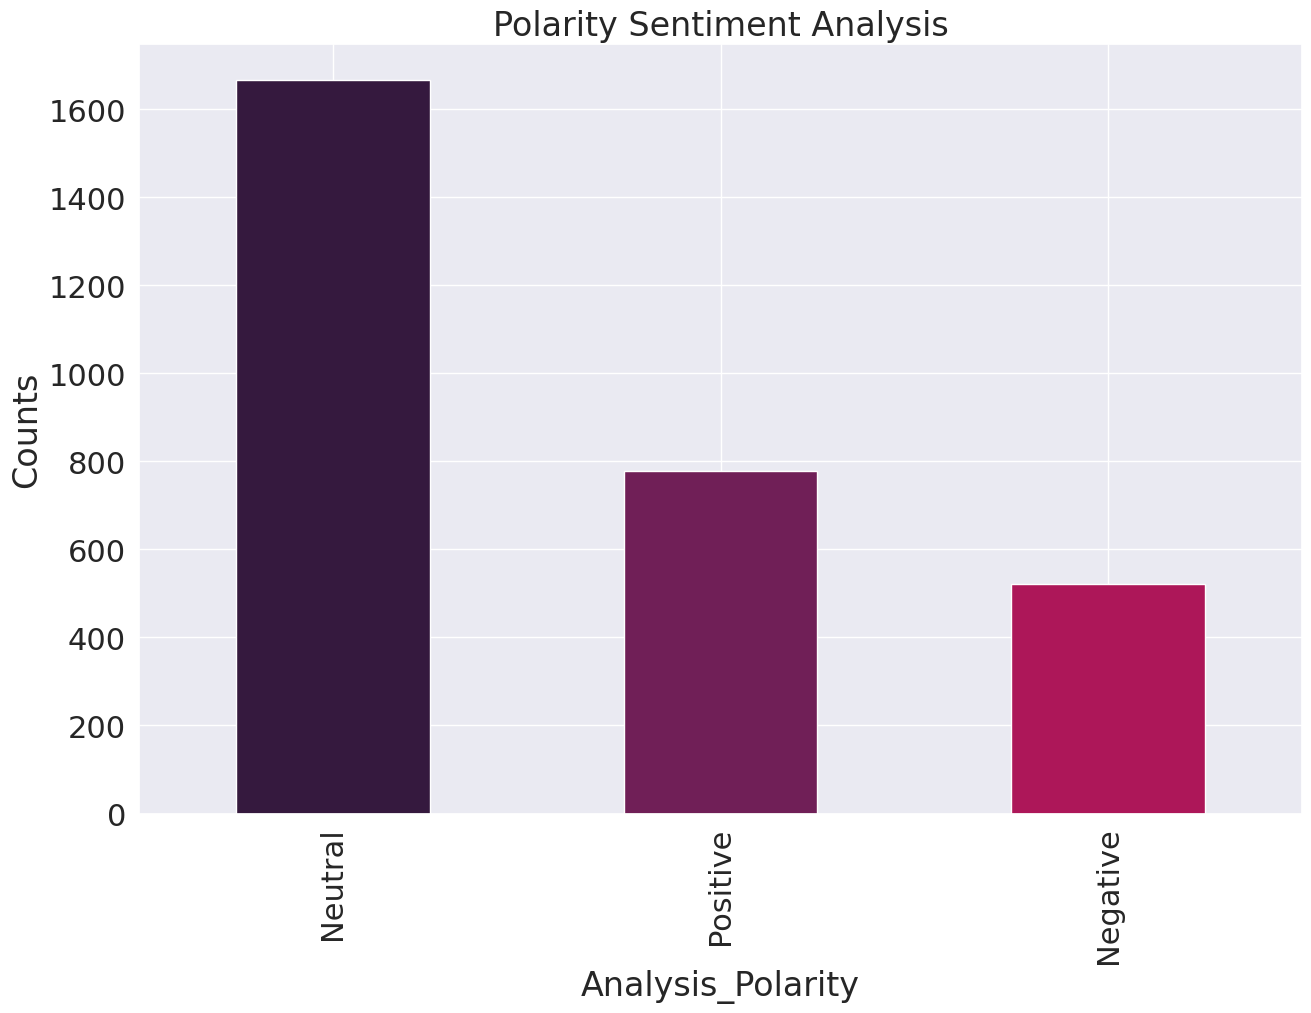

In [33]:

plt.figure(figsize=(15,10))

plt.title('Polarity Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis_Polarity'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('rocket'))
plt.show()

###Plot Subjectivity and Objective

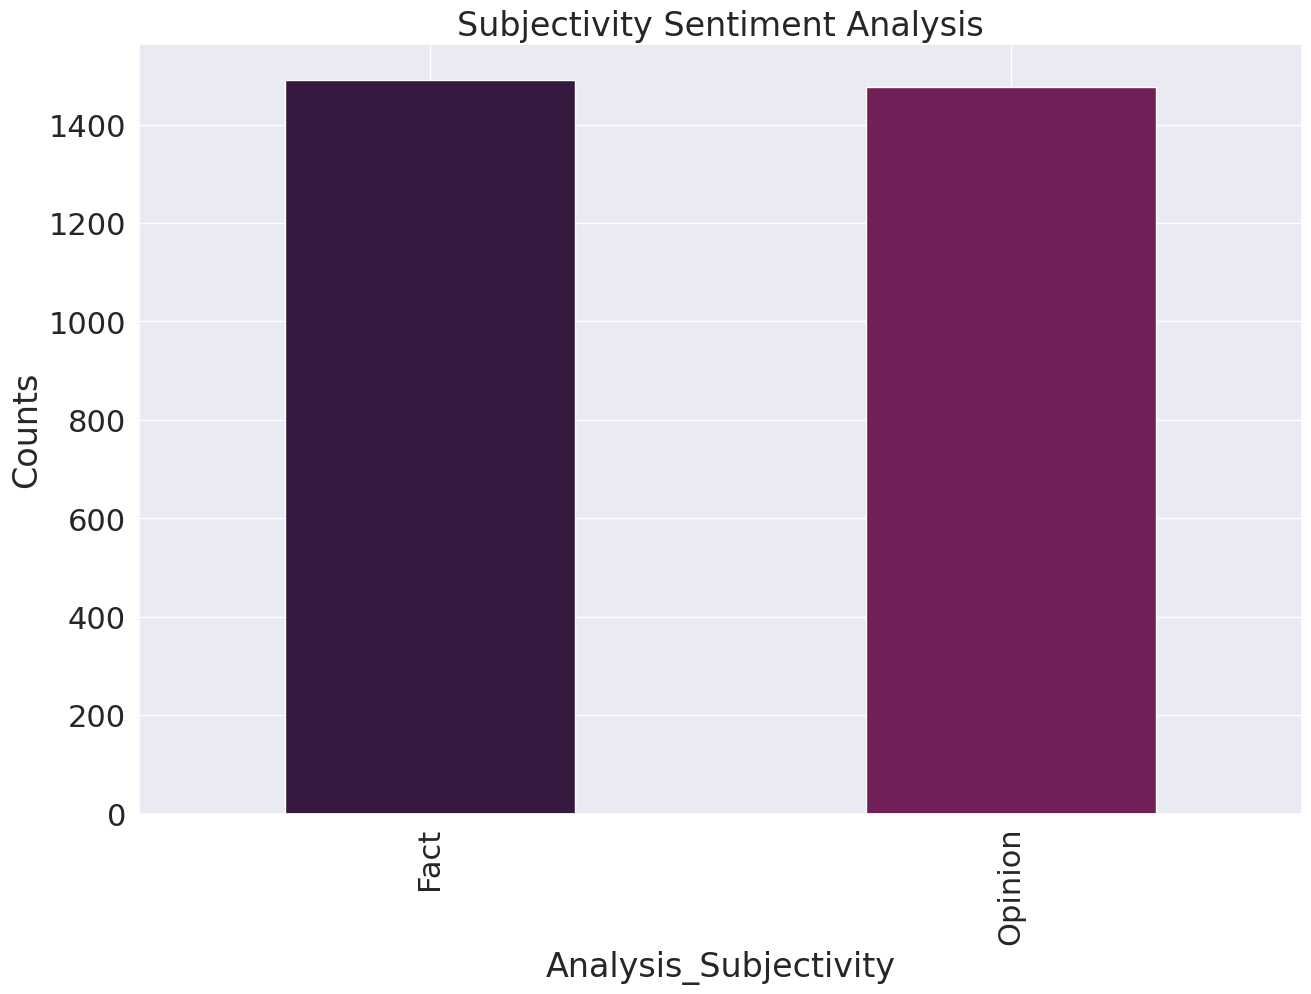

In [34]:
plt.figure(figsize=(15,10))
plt.title('Subjectivity Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis_Subjectivity'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('rocket'))
plt.show()


In [35]:
import pyLDAvis
import pyLDAvis.gensim
import pickle
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
!pip install gensim

In [36]:

pyLDAvis.enable_notebook()


In [37]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5,
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(df['cleaned_comments'].values.astype('U'))
print(dtm_tf.shape)

(2966, 656)


In [38]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_comments'].values.astype('U'))
print(dtm_tfidf.shape)

(2966, 656)


In [39]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components =10, random_state=50)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components =10, random_state=50)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(random_state=50)

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
import pyLDAvis.lda_model
...
pyLDAvis.lda_model.prepare

<function pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer, **kwargs)>

In [42]:
nltk.download('stopwords')
from nltk.corpus import stopwords  # Import the stopwords module

english_stopwords = stopwords.words('english')  # Call words on the module
english_stopwords.extend(['from', 'subject', 're', 'edu', 'use'])

def sentences_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuation.
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in english_stopwords] for doc in texts]

comments = df.cleaned_comments.to_list()
comment_words = list(sentences_to_words(comments))

# Remove stop words.
comment_words = remove_stopwords(comment_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
import gensim.corpora as corpora

# Create Dictionary.
id2word = corpora.Dictionary(comment_words)

# Create Corpus.
texts = comment_words

# Term Document Frequency.
corpus = [id2word.doc2bow(text) for text in texts]

In [57]:
from pprint import pprint

# Number of topics.
num_topics = 10

# Build LDA model.
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics
)

# Print the Keyword in the 10 topics.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"installed" + 0.025*"building" + 0.022*"products" + 0.014*"release" + '
  '0.012*"new" + 0.012*"press" + 0.010*"price" + 0.010*"company" + '
  '0.009*"delayed" + 0.009*"buy"'),
 (1,
  '0.015*"building" + 0.012*"installed" + 0.010*"products" + 0.010*"topbuild" '
  '+ 0.009*"shares" + 0.009*"eps" + 0.009*"reports" + 0.008*"consensus" + '
  '0.008*"target" + 0.007*"open"'),
 (2,
  '0.030*"building" + 0.030*"installed" + 0.029*"products" + 0.018*"sec" + '
  '0.016*"filed" + 0.015*"form" + 0.014*"release" + 0.013*"new" + '
  '0.011*"price" + 0.011*"delayed"'),
 (3,
  '0.026*"delayed" + 0.025*"filed" + 0.024*"form" + 0.017*"products" + '
  '0.016*"building" + 0.016*"installed" + 0.013*"earnings" + 0.012*"release" + '
  '0.012*"may" + 0.011*"sec"'),
 (4,
  '0.013*"building" + 0.011*"installed" + 0.010*"eps" + 0.010*"products" + '
  '0.007*"horton" + 0.006*"home" + 0.006*"earnings" + 0.006*"est" + '
  '0.005*"nan" + 0.005*"housing"'),
 (5,
  '0.020*"building" + 0.020*"products" +

In [58]:
import pyLDAvis
import pyLDAvis.gensim
import pickle
import os

# Visualize the topics.
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(f'cleaned_comments_lda_{num_topics}.data')

if os.path.exists(LDAvis_data_filepath):
    # Load the pre-prepared pyLDAvis data from disk.
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
else:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

pyLDAvis.save_html(LDAvis_prepared, f'{LDAvis_data_filepath}.html')

In [59]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.153159 -0.029382       1        1  13.686483
3     -0.070604  0.040156       2        1  12.271538
6     -0.078970 -0.043430       3        1  10.951050
0      0.000184  0.037129       4        1  10.761229
2      0.076826  0.151394       5        1  10.691189
8     -0.000749 -0.054367       6        1  10.415154
1     -0.101385  0.005172       7        1   9.799609
9     -0.064548  0.024120       8        1   7.396744
7      0.061748 -0.067052       9        1   7.386728
4      0.024339 -0.063740      10        1   6.640277, topic_info=            Term        Freq       Total Category  logprob  loglift
998        filed  487.000000  487.000000  Default  30.0000  30.0000
503     products  830.000000  830.000000  Default  29.0000  29.0000
441     building  921.000000  921.000000  Default  28.0000  28.0000
1808   installed  814.000000  814.000000  Default  27.0000  27.0000
903         form  547.000000  547.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
442      company   17.048120  294.848334  Topic10  -5.0528  -0.1384
203        price   16.264214  328.833346  Topic10  -5.0999  -0.2946
49      topbuild   13.970029  181.098833  Topic10  -5.2519   0.1499
331       shares   14.198498  231.196596  Topic10  -5.2357  -0.0781
749   securities   12.903419  146.060635  Topic10  -5.3314   0.2855

[766 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
4544      2  0.041878    abl
4544      7  0.083756    abl
4544      9  0.753801    abl
4544     10  0.041878    abl
1690      3  0.162850    abs
...     ...       ...    ...
920       4  0.448137    yoy
920       5  0.047172    yoy
920       6  0.023586    yoy
1161      2  0.627569  zener
1161      9  0.156892  zener

[2278 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 7, 1, 3, 9, 2, 10, 8, 5])

In [60]:
topic_values = lda_tf.transform(dtm_tf)
topic_values.shape

(2966, 10)

In [61]:
df.head()

,Date,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment,Topic
0,23/2/25,💎 MYNZ 🚀 NEW product hint and upcoming MAJOR p...,mynz new product hint and upcoming major partn...,0.477273,0.099432,Positive,Opinion,Positive Opinion,1
1,24/2/25,- TopBuild Corp. Common Stock - 10K - Updated ...,topbuild corp common stock 10k updated risk fa...,0.222222,-0.155556,Negative,Opinion,Negative Opinion,5
2,25/2/25,EXPANDED BUYBACK,expanded buyback,0.000000,0.000000,Neutral,Fact,Neutral Fact,0
3,25/2/25,"TopBuild sees 2025 revenue $5.05B-$5.35B, cons...",topbuild sees 2025 revenue 5 05b 5 35b consens...,0.000000,0.000000,Neutral,Fact,Neutral Fact,8
4,25/2/25,"TopBuild reports Q4 EPS $5.11, consensus $5.05...",topbuild reports q4 eps 5 11 consensus 5 05 re...,0.554808,0.220192,Positive,Opinion,Positive Opinion,7


In [73]:
df_1=df.replace({0:'Filings',1:'Stock Price Targets',2:'Quarterly Results & Guidance',3:'Earnings & Revenue',4:'SEC Filings & Stock Issuance',5:'Insider Ownership & Changes',6:'Trading & Investor Actions',7:'Investment & Valuation',8:'Company Acquisitions',9:'Housing & Market Trends'})

In [54]:
df_1['topic'] = topic_values.argmax(axis=1)

In [74]:
df['Topic'] = topic_values.argmax(axis=1)

In [75]:
df_1.head()

,Date,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment,Topic
0,23/2/25,💎 MYNZ 🚀 NEW product hint and upcoming MAJOR p...,mynz new product hint and upcoming major partn...,0.477273,0.099432,Positive,Opinion,Positive Opinion,Stock Price Targets
1,24/2/25,- TopBuild Corp. Common Stock - 10K - Updated ...,topbuild corp common stock 10k updated risk fa...,0.222222,-0.155556,Negative,Opinion,Negative Opinion,Insider Ownership & Changes
2,25/2/25,EXPANDED BUYBACK,expanded buyback,Filings,Filings,Neutral,Fact,Neutral Fact,Filings
3,25/2/25,"TopBuild sees 2025 revenue $5.05B-$5.35B, cons...",topbuild sees 2025 revenue 5 05b 5 35b consens...,Filings,Filings,Neutral,Fact,Neutral Fact,Company Acquisitions
4,25/2/25,"TopBuild reports Q4 EPS $5.11, consensus $5.05...",topbuild reports q4 eps 5 11 consensus 5 05 re...,0.554808,0.220192,Positive,Opinion,Positive Opinion,Investment & Valuation


In [76]:
df_1.columns

Index(['Date', 'Comment', 'cleaned_comments', 'Subjectivity', 'Polarity',
       'Analysis_Polarity', 'Analysis_Subjectivity', 'Sentiment', 'Topic'],
      dtype='object')

<Figure size 4000x2500 with 0 Axes>

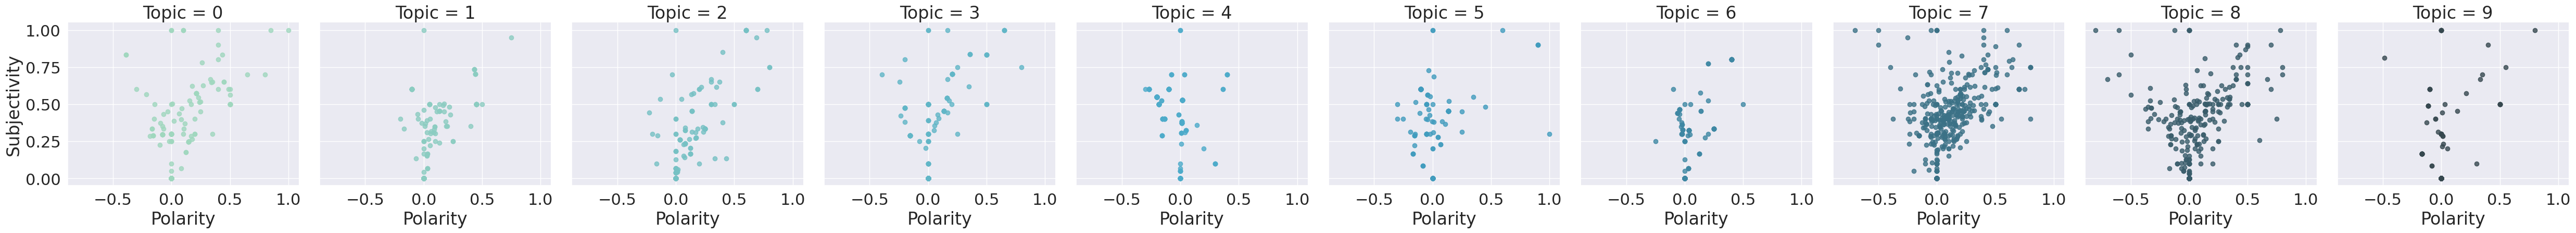

In [78]:
plt.figure(figsize=(40,25))

g=sns.lmplot(x="Polarity", y="Subjectivity", hue='Topic', data=df, fit_reg=False, legend=False,palette="GnBu_d", col='Topic', legend_out=True)


plt.show()

In [79]:
df_2 = df_1.groupby(['Topic'])['Analysis_Polarity'].value_counts().unstack('Topic').transpose()

df_2

Analysis_Polarity,Negative,Neutral,Positive
Topic,,,
Company Acquisitions,71,200,129
Earnings & Revenue,24,157,48
Filings,25,388,61
Housing & Market Trends,25,212,20
Insider Ownership & Changes,102,48,33
Investment & Valuation,80,150,236
Quarterly Results & Guidance,6,100,81
SEC Filings & Stock Issuance,144,22,61
Stock Price Targets,19,255,67


In [80]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, Company Acquisitions to Trading & Investor Actions
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Negative  10 non-null     int64
 1   Neutral   10 non-null     int64
 2   Positive  10 non-null     int64
dtypes: int64(3)
memory usage: 320.0+ bytes


In [81]:
df_2['Total'] = df_2.sum(axis=1)

In [82]:
df_2.columns

Index(['Negative', 'Neutral', 'Positive', 'Total'], dtype='object', name='Analysis_Polarity')

In [83]:
for i in df_2:
    df_2[i] = round(df_2[i]*100/df_2.Total)

df_2

Analysis_Polarity,Negative,Neutral,Positive,Total
Topic,,,,
Company Acquisitions,18.0,50.0,32.0,100.0
Earnings & Revenue,10.0,69.0,21.0,100.0
Filings,5.0,82.0,13.0,100.0
Housing & Market Trends,10.0,82.0,8.0,100.0
Insider Ownership & Changes,56.0,26.0,18.0,100.0
Investment & Valuation,17.0,32.0,51.0,100.0
Quarterly Results & Guidance,3.0,53.0,43.0,100.0
SEC Filings & Stock Issuance,63.0,10.0,27.0,100.0
Stock Price Targets,6.0,75.0,20.0,100.0


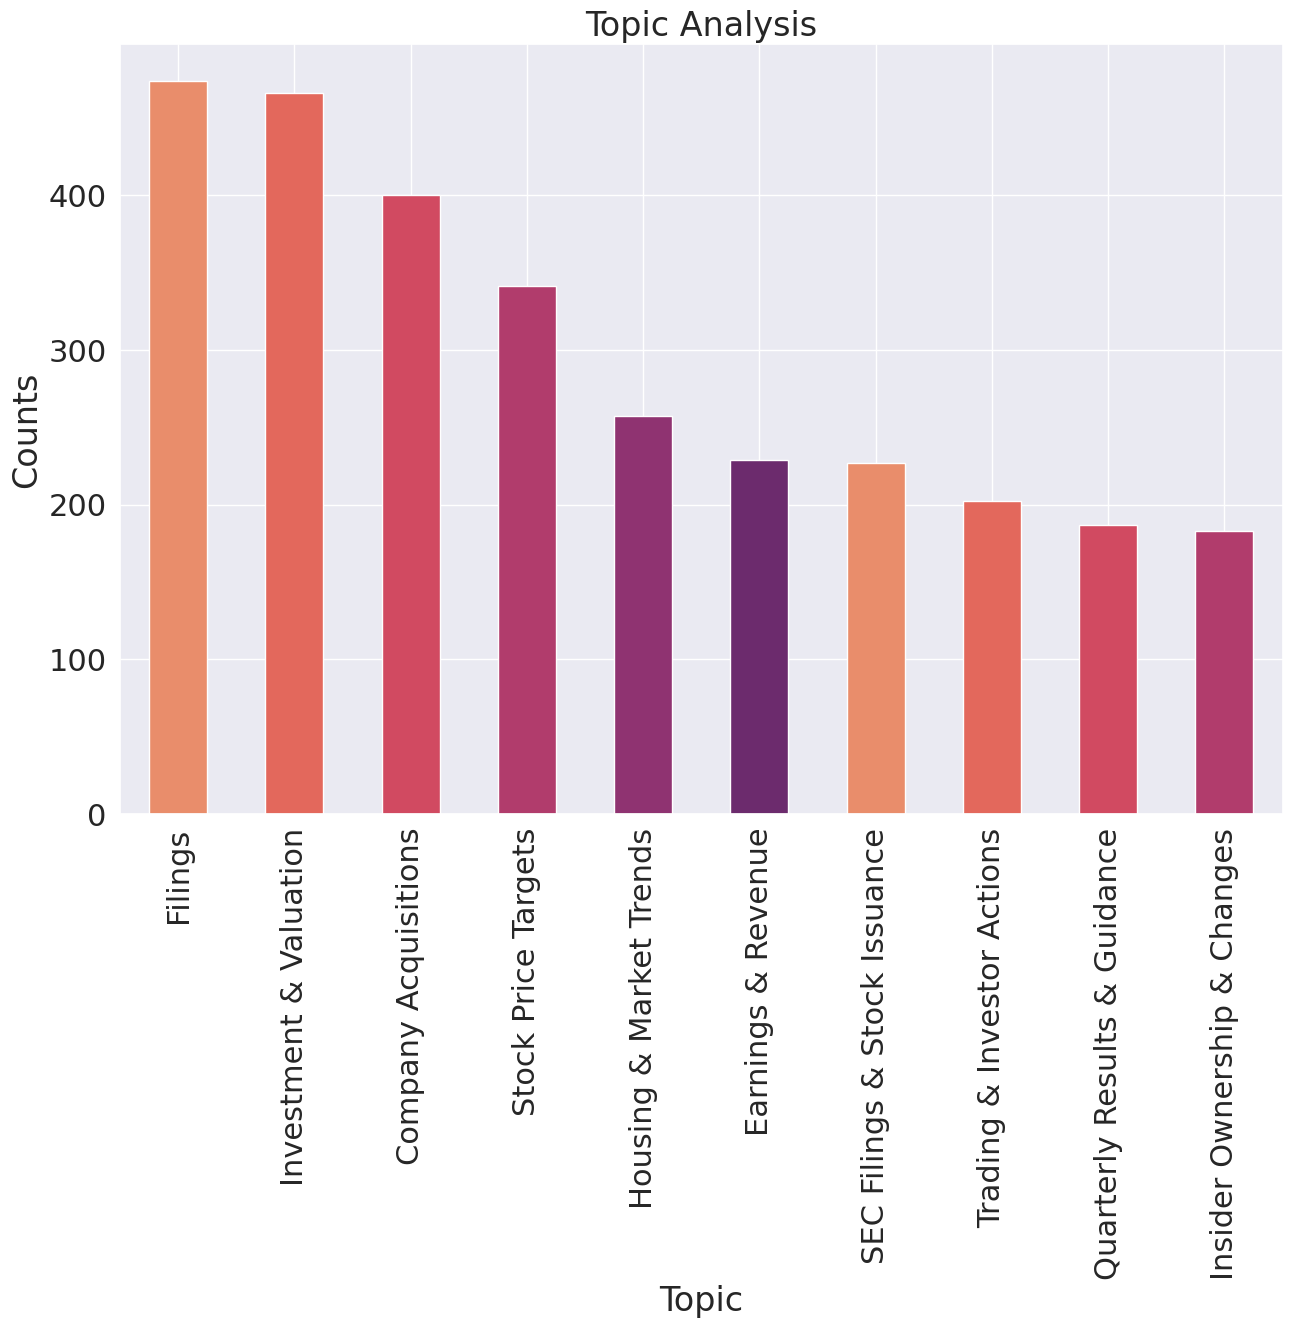

In [84]:
# Plot and visualizing the counts for each topic
plt.figure(figsize=(15,10))

plt.title('Topic Analysis')
plt.xlabel('Topic')
plt.ylabel('Counts')
df_1['Topic'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('flare'))
plt.show()


In [85]:
df_2=df_2.fillna(0)

In [86]:
df_2['Total'] = df_2.sum(axis=1)
df_2 = df_2.drop(['Total'], axis=1)

In [87]:
print(df_2.shape)

(10, 3)


In [88]:
print(df_2.head())

Analysis_Polarity            Negative  Neutral  Positive
Topic                                                   
Company Acquisitions             18.0     50.0      32.0
Earnings & Revenue               10.0     69.0      21.0
Filings                           5.0     82.0      13.0
Housing & Market Trends          10.0     82.0       8.0
Insider Ownership & Changes      56.0     26.0      18.0


In [89]:
print(df_2.tail())

Analysis_Polarity             Negative  Neutral  Positive
Topic                                                    
Investment & Valuation            17.0     32.0      51.0
Quarterly Results & Guidance       3.0     53.0      43.0
SEC Filings & Stock Issuance      63.0     10.0      27.0
Stock Price Targets                6.0     75.0      20.0
Trading & Investor Actions        12.0     66.0      21.0


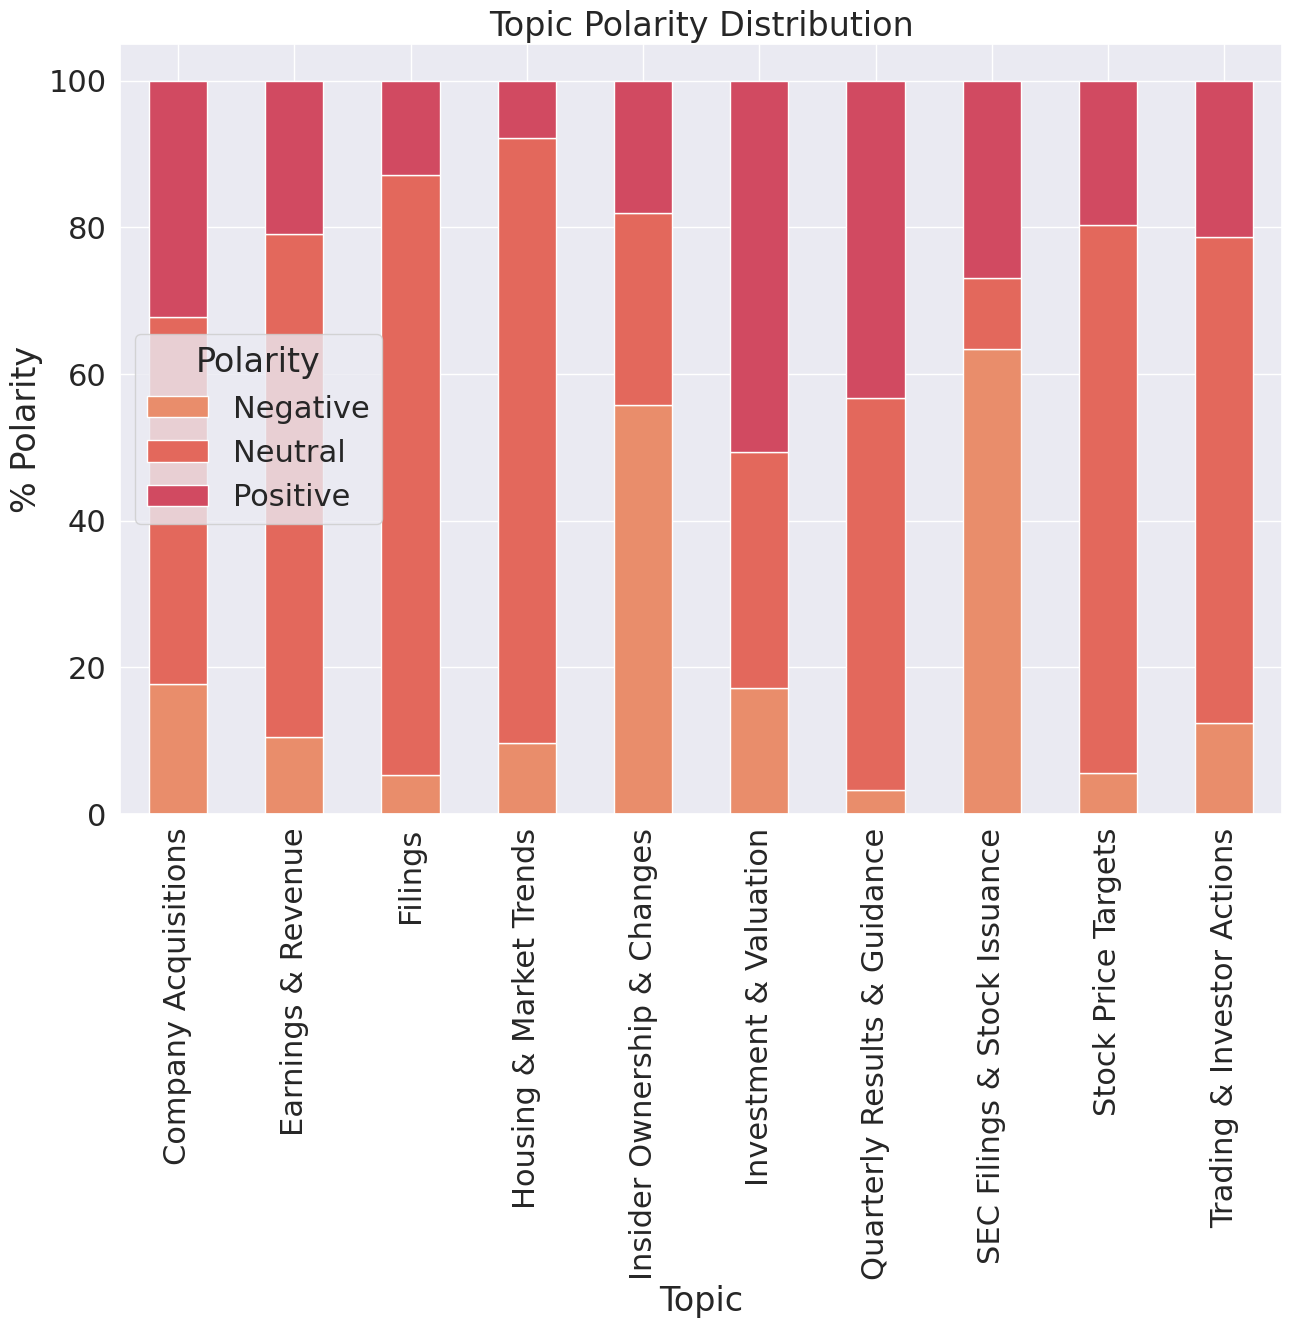

In [90]:
# Create a new dataframe with topic names and polarity percentages
df_topic_polarity = df_1.groupby('Topic')['Analysis_Polarity'].value_counts().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1)

# Create the stacked bar plot
ax = df_topic_polarity.plot(kind='bar',color=sns.palettes.mpl_palette('flare'), stacked=True, figsize=(15, 10))

# Add labels and title
ax.set_xlabel('Topic')
ax.set_ylabel('% Polarity')
ax.set_title('Topic Polarity Distribution')

# Add topic names to the x-axis
ax.set_xticklabels(df_topic_polarity.index, rotation=90)

# Add legend
ax.legend(title='Polarity')

# Show the plot
plt.show()


###Perform Topic Labeling to analyze the polarity score of each of the topics identified.

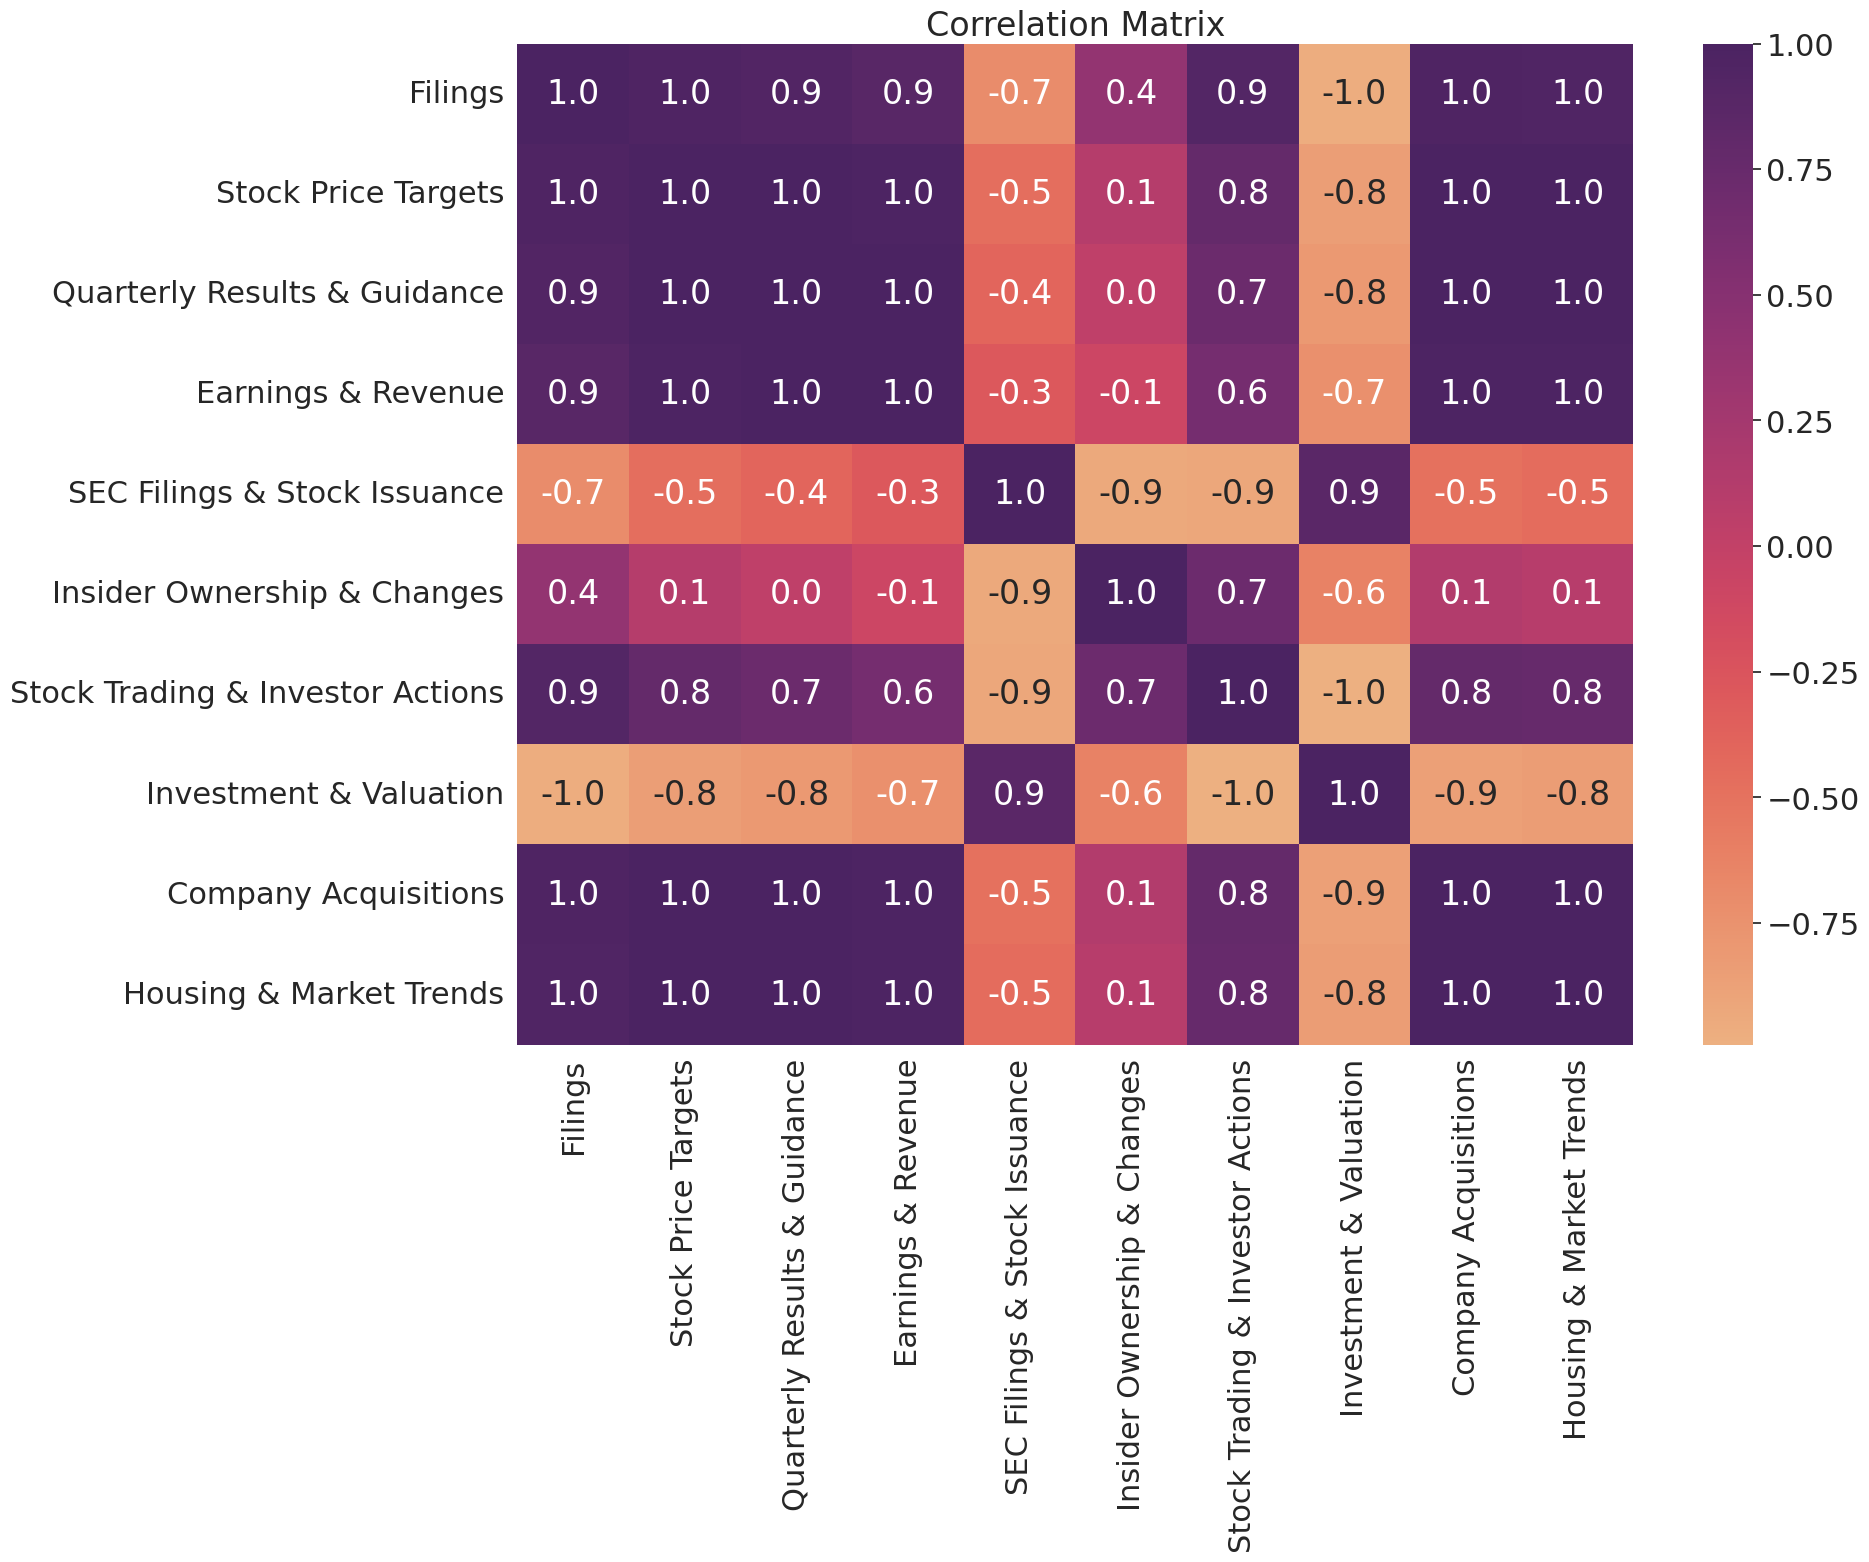

In [92]:
# Define the data
topic_names = [
    "Filings",
    "Stock Price Targets",
    "Quarterly Results & Guidance",
    "Earnings & Revenue",
    "SEC Filings & Stock Issuance",
    "Insider Ownership & Changes",
    "Stock Trading & Investor Actions",
    "Investment & Valuation",
    "Company Acquisitions",
    "Housing & Market Trends",]

# Get the topic-polarity matrix
topic_polarity_matrix = df_topic_polarity.values

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(topic_polarity_matrix)
fig, ax = plt.subplots(figsize=(18, 13))
sns.heatmap(correlation_matrix, annot=True, cmap="flare", fmt=".1f", xticklabels=topic_names, yticklabels=topic_names)
plt.title("Correlation Matrix")
plt.show()

###Plot dendongram chart for the topic identified

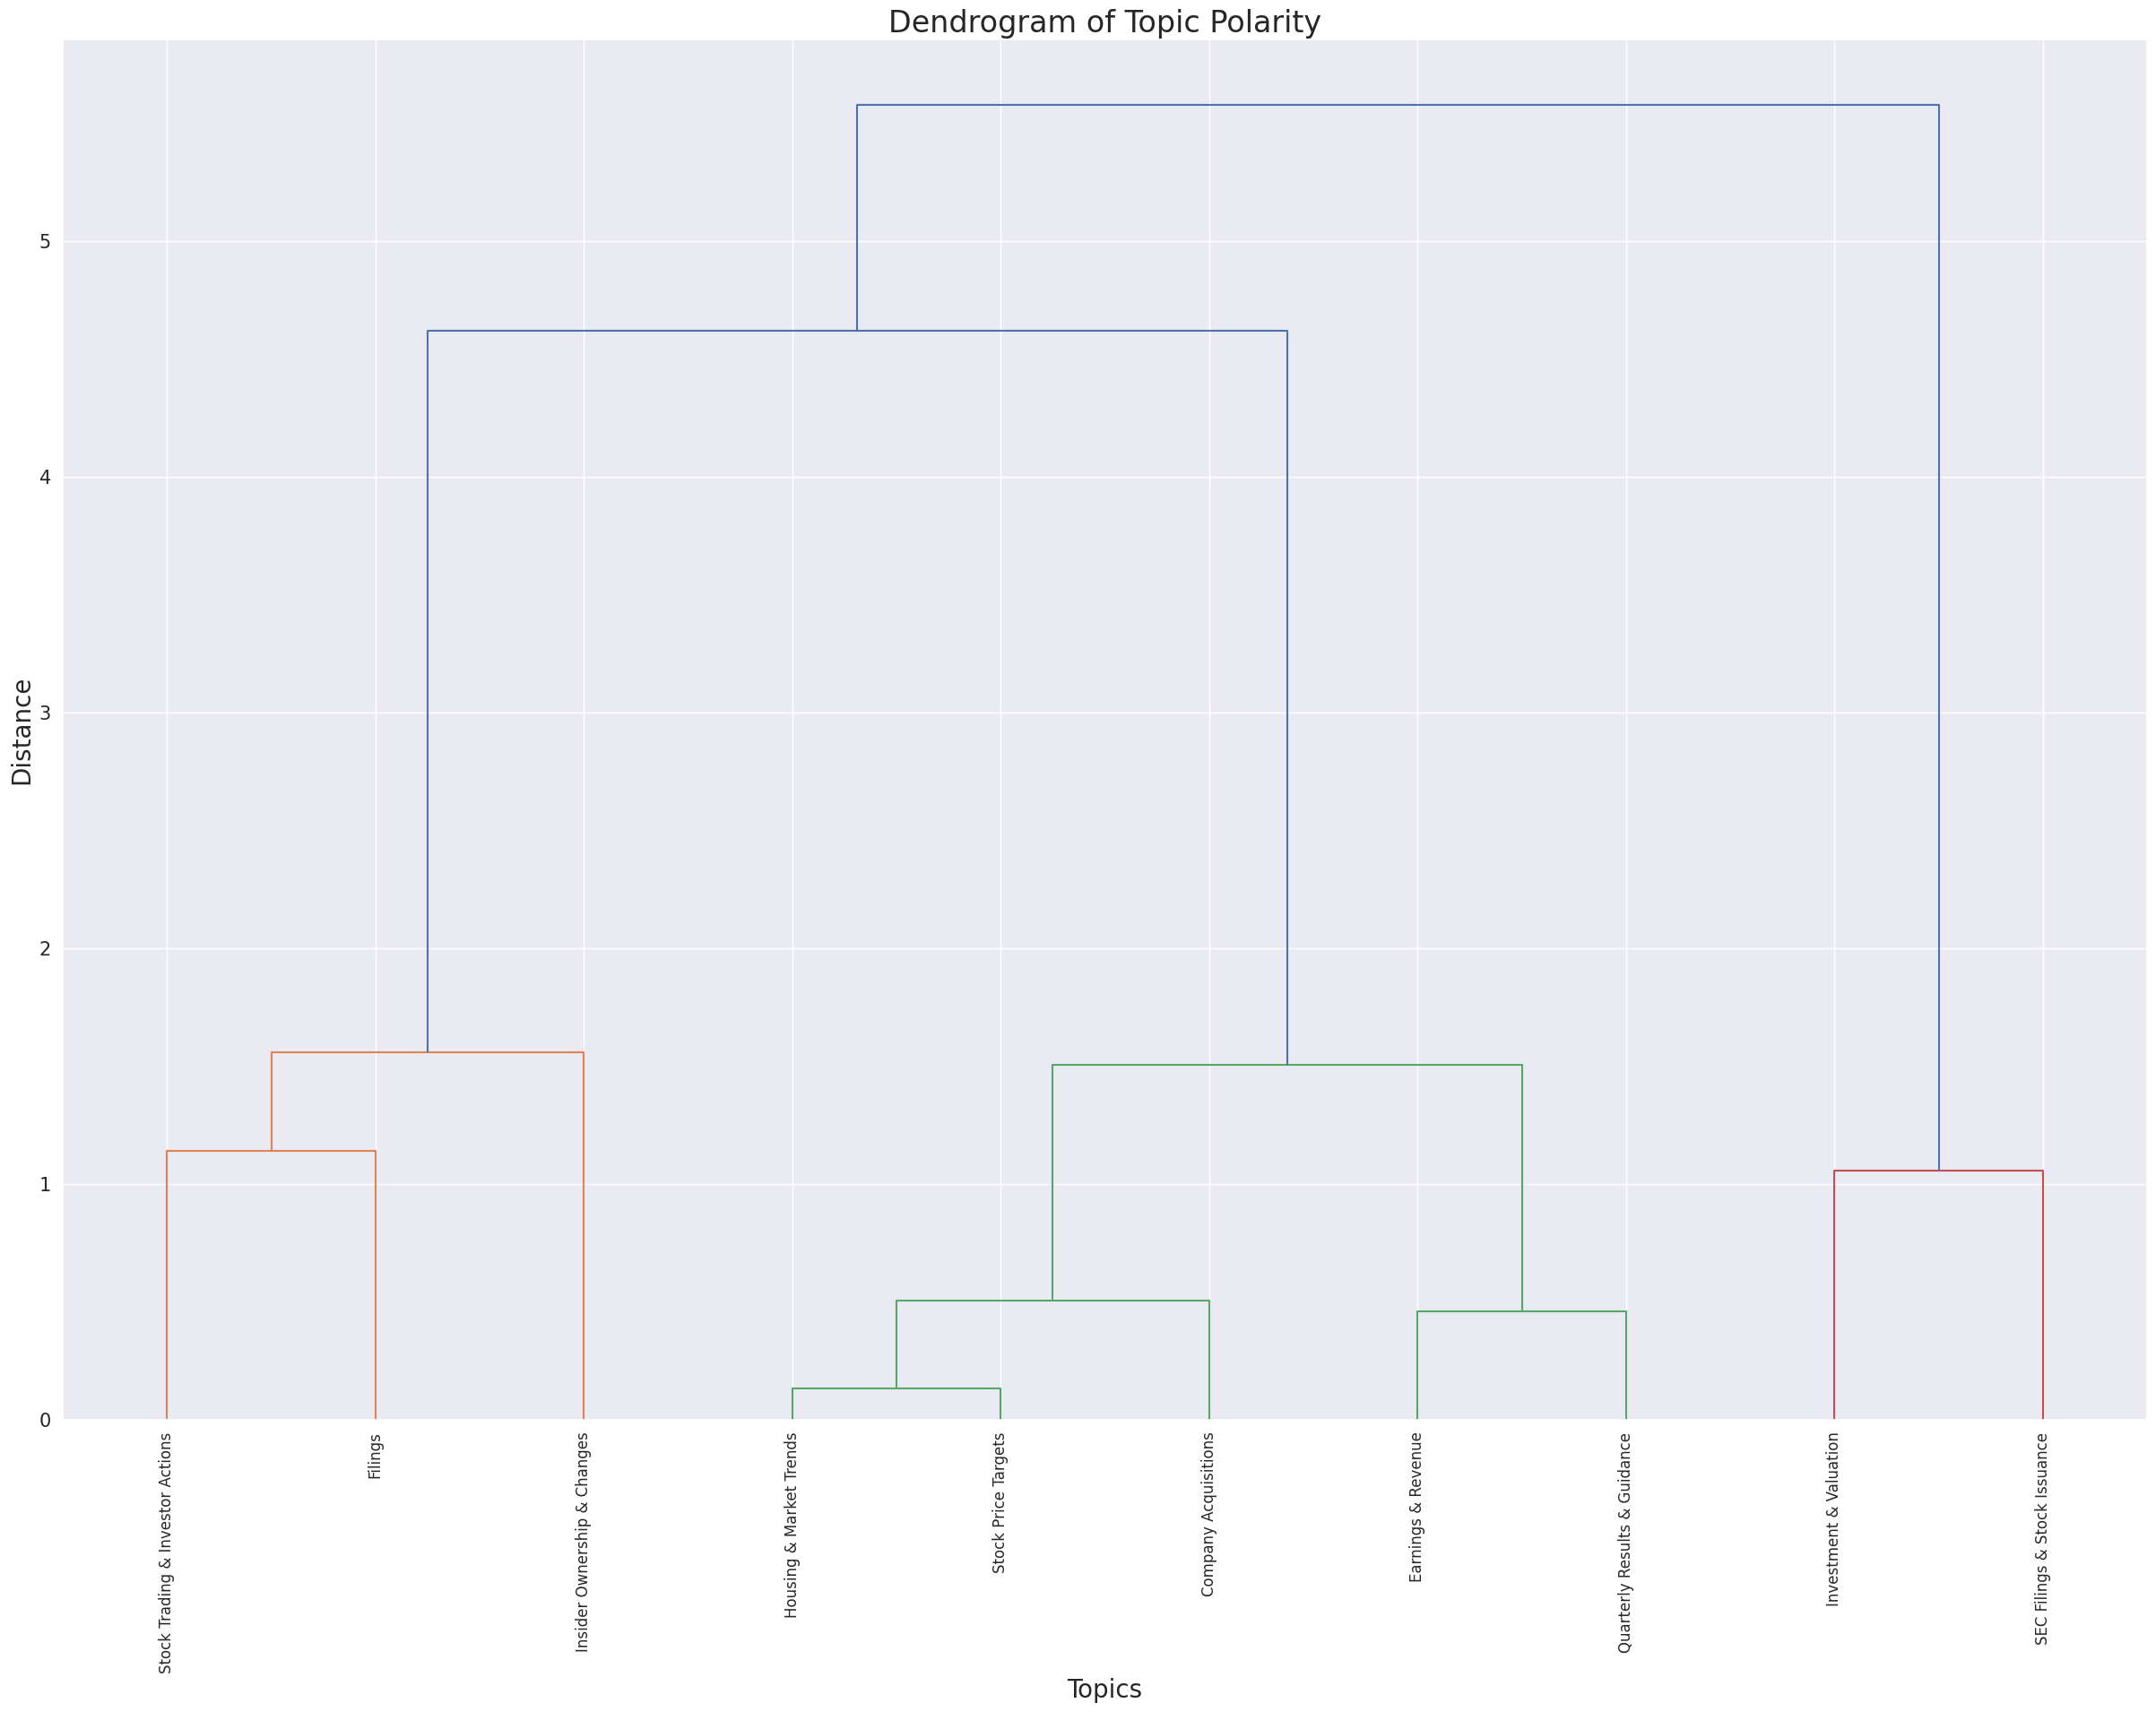

In [93]:

import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler

# Standardize the topic-polarity matrix
scaler = StandardScaler()
scaled_topic_polarity_matrix = scaler.fit_transform(topic_polarity_matrix)

# Calculate the linkage
linkage_matrix = sch.linkage(scaled_topic_polarity_matrix, method='ward')

# Create the dendrogram
plt.figure(figsize=(30, 20))
sch.dendrogram(linkage_matrix, orientation='top', distance_sort='descending', labels=topic_names)
plt.title('Dendrogram of Topic Polarity', size=24)
plt.xlabel('Topics', size=20)
plt.ylabel('Distance', size=20)
plt.tick_params(axis='x', rotation=90)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.show()


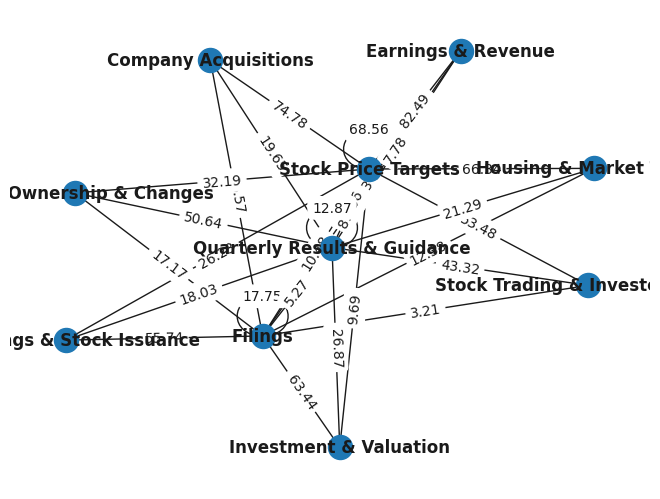

In [94]:
# Create a graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(topic_names)

# Add edges to the graph based on the polarity matrix
for i in range(len(topic_polarity_matrix)):
    for j in range(len(topic_polarity_matrix[0])):
        if topic_polarity_matrix[i][j] > 0.5:
            G.add_edge(topic_names[i], topic_names[j], weight=topic_polarity_matrix[i][j])

# Set the layout of the nodes
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, font_weight='bold')

# Set the edge labels
edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()


###Load libraries for Network Analysis

###Check for the degree of centrality and betweenness for the topics identified

In [95]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Print the results
print("Degree Centrality:")
for node, centrality in degree_centrality.items():
    print(f"{node}: {centrality}")

print("\nBetweenness Centrality:")
for node, centrality in betweenness_centrality.items():
    print(f"{node}: {centrality}")


Degree Centrality:
Filings: 1.222222222222222
Stock Price Targets: 1.222222222222222
Quarterly Results & Guidance: 1.222222222222222
Earnings & Revenue: 0.3333333333333333
SEC Filings & Stock Issuance: 0.3333333333333333
Insider Ownership & Changes: 0.3333333333333333
Stock Trading & Investor Actions: 0.3333333333333333
Investment & Valuation: 0.3333333333333333
Company Acquisitions: 0.3333333333333333
Housing & Market Trends: 0.3333333333333333

Betweenness Centrality:
Filings: 0.19444444444444442
Stock Price Targets: 0.19444444444444442
Quarterly Results & Guidance: 0.19444444444444442
Earnings & Revenue: 0.0
SEC Filings & Stock Issuance: 0.0
Insider Ownership & Changes: 0.0
Stock Trading & Investor Actions: 0.0
Investment & Valuation: 0.0
Company Acquisitions: 0.0
Housing & Market Trends: 0.0


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

# Assuming 'Analysis_Polarity' is your target variable and other relevant features are in X
X = df[['Polarity', 'Subjectivity', 'Topic']]  # Example features, replace with your actual features
y = df['Analysis_Polarity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC(gamma='scale')))
models.append(('RFC', RandomForestClassifier(n_estimators=100)))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('GBC', GradientBoostingClassifier()))


# Evaluate models
results = []
names = []
for name, model in models:
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model: {name}, Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        results.append(accuracy)
        names.append(name)
    except Exception as e:  # Handle potential errors during model training/prediction
        print(f"Error with model {name}: {e}")
        results.append(0)
        names.append(name)


Model: LR, Accuracy: 0.9511784511784511
              precision    recall  f1-score   support

    Negative       0.97      0.93      0.95       102
     Neutral       0.95      0.97      0.96       338
    Positive       0.95      0.92      0.93       154

    accuracy                           0.95       594
   macro avg       0.96      0.94      0.95       594
weighted avg       0.95      0.95      0.95       594

Model: KNN, Accuracy: 0.9797979797979798
              precision    recall  f1-score   support

    Negative       0.98      0.96      0.97       102
     Neutral       0.98      1.00      0.99       338
    Positive       0.98      0.95      0.97       154

    accuracy                           0.98       594
   macro avg       0.98      0.97      0.98       594
weighted avg       0.98      0.98      0.98       594

Model: NB, Accuracy: 0.9781144781144782
              precision    recall  f1-score   support

    Negative       0.94      0.97      0.96       102
     Neu

In [99]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

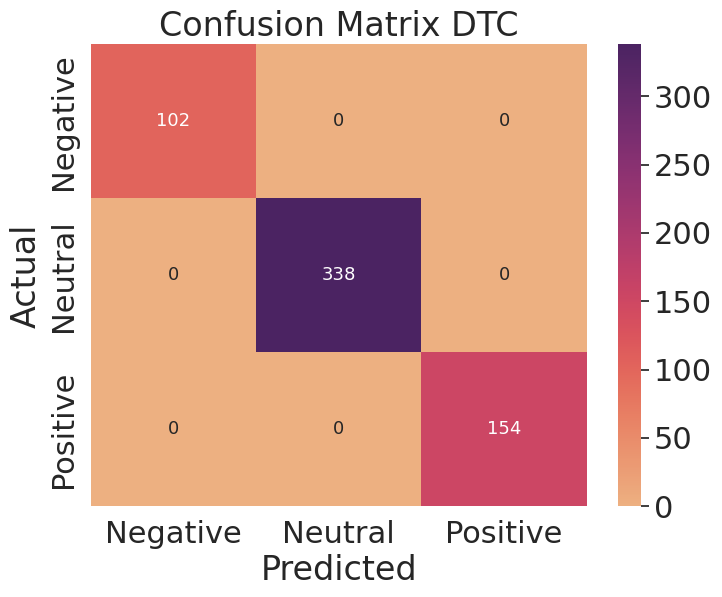

In [100]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            annot_kws={"size": 13})
plt.title("Confusion Matrix DTC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()